In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import rasterio
import cv2
from PIL import Image

from dataset import VPCHM
from models.generator import UnetGenerator
from models.discriminator import Discriminator
from utils import init_weights

### Load dataset

In [2]:
# input1_path="./data/input1"
# input2_path="./data/input2"
# input3_path="./data/input3"
# target_path="./data/target"
# input_path=[input1_path, input2_path, input3_path]

In [3]:
input1_path="./data/input_naip_2012"
input2_path="./data/input_naip_2014"
input3_path="./data/input_naip_2016"
target_path="./data/target_chm"
input_path=[input1_path, input2_path, input3_path]

In [ ]:
train=VPCHM(input_path, target_path, partition='train', upscaling=110, padding_dim=(1200, 1200), output_dim=1024)
val=VPCHM(input_path, target_path, partition='val', upscaling=110, padding_dim=(1200, 1200), output_dim=1024)
test=VPCHM(input_path, target_path, partition='test', upscaling=110, padding_dim=(1200, 1200), output_dim=1024)

/home/hoang/anaconda3/envs/midas/lib/python3.10/site-packages/rasterio/__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [4]:
batch_size=32

In [5]:
train_dl = DataLoader(train, batch_size, shuffle=True)
val_dl = DataLoader(val, batch_size)
test_dl = DataLoader(test, batch_size)

### Define generator-discriminator

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
generator = UnetGenerator(3, 1, 64, use_dropout=False).cuda().float()
init_weights(generator, 'normal', scaling=0.02)

initialize network with normal


In [8]:
discriminator=Discriminator(4, 64).cuda().float()

### Loss function

In [9]:
adversarial_loss = nn.BCELoss() 
l1_loss = nn.L1Loss()

def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100 * l1_l)
    return gen_total_loss

def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

### Training

In [10]:
num_epochs = 200
model = [generator, discriminator]

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import time

def training(model,
             train_dl,
             test_dl=None,
             num_epochs:int=50,
             lr:float=0.0001,
             patch_dim:tuple=(30, 30)):
    '''
    model: list [generator, discriminator]
    train_dl: data_loader for training set
    test_ld: data_loader for val/test set
    num_epochs: num of training epochs
    patch_dim: dim of patch returned by discriminator
    '''
    generator, discriminator=model[0], model[1]
    G_optimizer=torch.optim.Adam(generator.parameters(), lr=lr)
    D_optimizer=torch.optim.Adam(discriminator.parameters(), lr=lr)
    G_train_losses, D_train_losses = [], []
    G_test_losses, D_test_losses = [], []
    #===========================
    #Training
    for epoch in range(1, num_epochs+1): 
        generator.train()
        discriminator.train()
        G_train_loss=D_train_loss= 0.0
        start=time.time()
        num_batch=len(train_dl.dataset)
        for input_img, target_img in train_dl:
            D_optimizer.zero_grad()
            input_img=input_img[:,:,:256,:256].to(device)
            target_img=target_img[:,:,:256,:256].to(device)
            #ground truth labels real and fake
            real_target=Variable(torch.ones(input_img.size(0), 1, patch_dim[0], patch_dim[1]).to(device))
            fake_target=Variable(torch.zeros(input_img.size(0), 1, patch_dim[0], patch_dim[1]).to(device))
            #generator forward pass
            generated_image=generator(input_img)
            #train discriminator with fake/generated images
            disc_inp_fake=torch.cat((input_img, generated_image), 1)
            D_fake=discriminator(disc_inp_fake.detach())
            D_fake_loss=discriminator_loss(D_fake, fake_target)
            #train discriminator with real images
            disc_inp_real=torch.cat((input_img, target_img), 1)
            D_real=discriminator(disc_inp_real)
            D_real_loss=discriminator_loss(D_real,  real_target)
            #average discriminator loss
            D_total_loss=(D_real_loss + D_fake_loss)/2
            D_train_loss+=D_total_loss
            #compute gradients and run optimizer step
            D_total_loss.backward()
            D_optimizer.step()
            #train generator with real labels
            G_optimizer.zero_grad()
            fake_gen=torch.cat((input_img, generated_image), 1)
            G=discriminator(fake_gen)
            G_loss=generator_loss(generated_image, target_img, G, real_target)                                 
            G_train_loss+=G_loss
            #compute gradients and run optimizer step
            G_loss.backward()
            G_optimizer.step()
        G_train_losses.append(G_train_loss.detach().cpu().numpy()/num_batch)
        D_train_losses.append(D_train_loss.detach().cpu().numpy()/num_batch)
        end=time.time()
        print(f"Epoch {epoch} - G loss: {G_loss/num_batch}, D loss: {D_total_loss/num_batch}, Time: {end-start}")
        #===========================
        #Test/Validate
        if test_dl!=None:
            generator.eval()
            discriminator.eval()
            with torch.no_grad():
                num_batch=len(test_dl.dataset)
                G_test_loss=D_test_loss=0.0
                for input_img, target_img in test_dl:
                    input_img=input_img[:,:,:256,:256].to(device)
                    target_img=target_img[:,:,:256,:256].to(device)
                    #ground truth labels real and fake
                    real_target=Variable(torch.ones(input_img.size(0), 1, patch_dim[0], patch_dim[1]).to(device))
                    fake_target=Variable(torch.zeros(input_img.size(0), 1, patch_dim[0], patch_dim[1]).to(device))
                    #generator forward pass
                    generated_image=generator(input_img)
                    #train discriminator with fake/generated images
                    disc_inp_fake=torch.cat((input_img, generated_image), 1)
                    D_fake=discriminator(disc_inp_fake.detach())
                    D_fake_loss=discriminator_loss(D_fake, fake_target)
                    #train discriminator with real images
                    disc_inp_real=torch.cat((input_img, target_img), 1)
                    D_real=discriminator(disc_inp_real)
                    D_real_loss=discriminator_loss(D_real,  real_target)
                    #average discriminator loss
                    D_total_loss=(D_real_loss + D_fake_loss)/2
                    D_test_loss+=D_total_loss
                    #train generator with real labels
                    fake_gen=torch.cat((input_img, generated_image), 1)
                    G=discriminator(fake_gen)
                    G_loss=generator_loss(generated_image, target_img, G, real_target)                                 
                    G_test_loss+=G_loss
                G_test_losses.append(G_test_loss.detach().cpu().numpy()/num_batch)
                D_test_losses.append(D_test_loss.detach().cpu().numpy()/num_batch)
                print(f"Epoch {epoch} - G loss: {G_test_loss/num_batch}, D loss: {D_test_loss/num_batch}")
        #===========================
    if test_dl!=None:
        return (G_train_losses, D_train_losses), (G_test_losses, D_test_losses)  
    else:
        return (G_train_losses, D_train_losses)

In [12]:
outcome=training(model, train_dl, val_dl, lr=0.001)

Epoch 1 - G loss: 0.1267463117837906, D loss: 0.0025457474403083324, Time: 9.655233144760132
Epoch 1 - G loss: 2.519608497619629, D loss: 0.04124068468809128
Epoch 2 - G loss: 0.07558244466781616, D loss: 0.0019425724167376757, Time: 7.745206594467163
Epoch 2 - G loss: 1.8479337692260742, D loss: 0.04596154764294624
Epoch 3 - G loss: 0.10073165595531464, D loss: 0.001331311883404851, Time: 7.665757894515991
Epoch 3 - G loss: 1.8949083089828491, D loss: 0.03571808710694313
Epoch 4 - G loss: 0.11195908486843109, D loss: 0.0005216829595156014, Time: 7.574885129928589
Epoch 4 - G loss: 1.7005436420440674, D loss: 0.04198713228106499
Epoch 5 - G loss: 0.1088361144065857, D loss: 0.0001905750104924664, Time: 7.594177722930908
Epoch 5 - G loss: 1.9704562425613403, D loss: 0.07780814915895462
Epoch 6 - G loss: 0.11158282309770584, D loss: 8.655177225591615e-05, Time: 8.325144529342651
Epoch 6 - G loss: 1.8266716003417969, D loss: 0.06765774637460709
Epoch 7 - G loss: 0.11268855631351471, D los

In [13]:
train_losses, val_losses=outcome

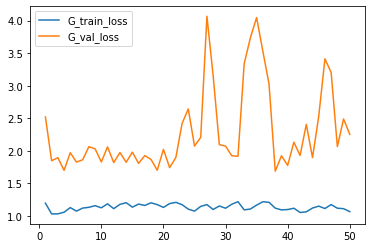

In [26]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,51), train_losses[0], label="G_train_loss")
plt.plot(np.arange(1,51), val_losses[0], label="G_val_loss")
plt.legend(loc='upper left')

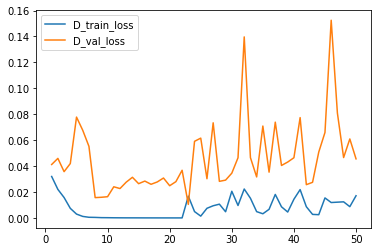

In [27]:
plt.plot(np.arange(1,51), train_losses[1], label="D_train_loss")
plt.plot(np.arange(1,51), val_losses[1], label="D_val_loss")
plt.legend(loc='upper left')

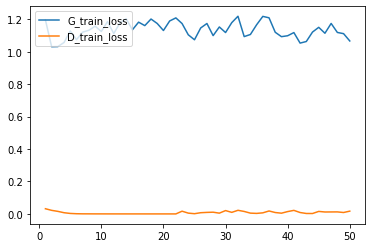

In [28]:
plt.plot(np.arange(1,51), train_losses[0], label="G_train_loss")
plt.plot(np.arange(1,51), train_losses[1], label="D_train_loss")
plt.legend(loc='upper left')